# CarND Behavioral Cloning Project

This project is about training a neural network to drive a car on a simulator using data recorded from a humman driver.

This notebook will be used to create the model to be used in driving the car on the simulator.

The inputs come in three images right, central and left cameras.

The first thing to do is to clean, then oganize the dataset, and save it to pickle file. for posterior use.

The file driving_log.csv contains steering angles and the left, right and center images associated to it.

In [1]:
import pickle
import csv
import numpy as np
import cv2

path_to_replace = "C:\\Users\\eduardo\\Documents\\SelfDrivingCar\\simulator-windows-64\\"

def ReplaceWrongPath(value):
    return value.replace(path_to_replace, "").replace("\\", "/").replace(" data", "data")

imgs = []
labels = []

with open('./data/driving_log.csv', 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        
        angle = float(row[3])
        
        if (angle == 0 and np.random.randint(0,1) == 0):
            continue
            
        b,g,r = cv2.split(cv2.imread('./' + ReplaceWrongPath(row[0])))
        imgs.append(np.array(cv2.merge([r,g,b])))
        labels.append(angle)
        
        if (angle > 0 and angle < 0.8):
            b,g,r = cv2.split(cv2.imread('./' + ReplaceWrongPath(row[1])))
            imgs.append(np.array(cv2.merge([r,g,b])))
            labels.append(float(row[3]) * 0.8)
            b,g,r = cv2.split(cv2.imread('./' + ReplaceWrongPath(row[2])))
            imgs.append(np.array(cv2.merge([r,g,b])))
            labels.append(float(row[3]) * 1.2)
        elif (angle < 0 and angle > -0.8 ):
            b,g,r = cv2.split(cv2.imread('./' + ReplaceWrongPath(row[1])))
            imgs.append(np.array(cv2.merge([r,g,b])))
            labels.append(float(row[3]) * 1.2)
            b,g,r = cv2.split(cv2.imread('./' + ReplaceWrongPath(row[2])))
            imgs.append(np.array(cv2.merge([r,g,b])))
            labels.append(float(row[3]) * 0.8)
        
pickle.dump({"features": imgs, "labels": labels }, open( "driving_data.p", "wb" ))

print("pickling done")

### Load data 

In [2]:
training_file = 'driving_data.p'

with open(training_file, mode='rb') as f:
    data = pickle.load(f)

X_train = data['features']
y_train = data['labels']

### Explore data

1.0
-1.0


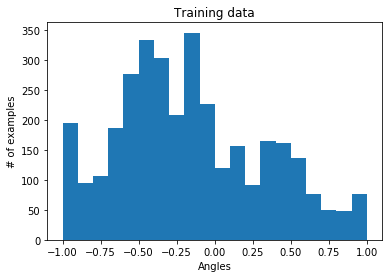

In [3]:
import matplotlib.pyplot as plt

print (np.max(y_train))
print (np.min(y_train))

plt.hist(y_train, bins=20)
plt.title("Training data")
plt.xlabel("Angles")
plt.ylabel("# of examples")
plt.show()

(160L, 320L, 3L)
0.7789792
2344


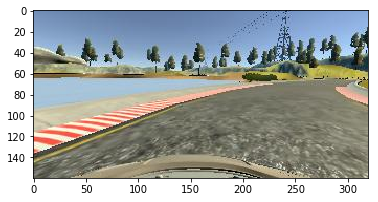

In [4]:

# Visualizations will be shown in the notebook.
%matplotlib inline

rand_image_index = np.random.randint(0, len(X_train))
#plt.figure(figsize=(1,1))
plt.imshow(X_train[rand_image_index].squeeze())
print(np.shape(X_train[rand_image_index]))
print(y_train[rand_image_index])
print(rand_image_index)

### Resize

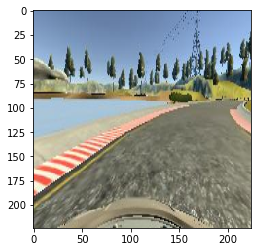

In [5]:
img_resized = cv2.resize(X_train[rand_image_index], (224, 224))
plt.imshow(img_resized.squeeze())


### Normalize

In [6]:
def Normalize(image_data):
    a = -0.5
    b = 0.5
    img_min = 0
    img_max = 255
    return a + ( ( (image_data - img_min)*(b - a) )/( img_max - img_min ) )
    
X_normalized = Normalize(np.array(X_train))

print("Min", np.min(X_normalized))
print("Max", np.max(X_normalized))
print("Std", np.std(X_normalized))

('Min', -0.5)
('Max', 0.5)
('Std', 0.2077508958260012)


# Model

#### VGG with drop out, batch normalition

#### 20 EPOCHS Adam optimizer linear regression

#### Validation


In [9]:
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
import numpy as np

base_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = Flatten(input_shape=x.shape)(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1000, activation='relu')(x)
predictions = Dense(1, activation='tanh')(x)

model = Model(input=base_model.input, output=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='sgd',
          loss='mean_squared_error',
          metrics=['accuracy'])

history = model.fit(X_normalized, y_train, batch_size=128, nb_epoch=20, validation_split=0.35)

ImportError: No module named applications.vgg16